In [25]:
import os
import scipy
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))
import matplotlib.pyplot as plt

import io
import requests

import datetime as dt
from dateutil.relativedelta import *

import netCDF4
from netCDF4 import Dataset, num2date

import cmocean

import seaborn as sns
import pymannkendall as mk

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12,7)
%matplotlib inline

In [27]:
month = 3
year = 2017
netCDF_datestr = str(year)+'-'+format(month, '02')

# GBR4 HYDRO
hydrofiles = [f'https://thredds.nci.org.au/thredds/dodsC/fx3/gbr4_v2/gbr4_simple_2017-03.nc']

ds_hydro = xr.open_mfdataset(hydrofiles)

# GBR4 BIO
biofiles = [f'https://thredds.nci.org.au/thredds/dodsC/fx3/gbr4_bgc_GBR4_H2p0_B3p1_Cq3b_Dhnd/gbr4_bgc_all_simple_2017-03.nc']

ds_bio = xr.open_mfdataset(biofiles)

Note:Caching=1
Note:Caching=1


In [28]:
ds_hydro
list(ds_hydro.keys())

# Define the time range
start_date = '2017-03-24'
end_date = '2017-03-30'

# Slice the dataset based on the time range
ds_hydro_slice = ds_hydro.sel(time=slice(start_date, end_date))

# Display the sliced dataset
ds_hydro_slice


<xarray.Dataset>
Dimensions:      (k: 47, j: 180, i: 600, time: 168)
Coordinates:
    zc           (k) float64 dask.array<chunksize=(47,), meta=np.ndarray>
    longitude    (j, i) float64 dask.array<chunksize=(180, 600), meta=np.ndarray>
    latitude     (j, i) float64 dask.array<chunksize=(180, 600), meta=np.ndarray>
  * time         (time) datetime64[ns] 2017-03-24 ... 2017-03-30T23:00:00
Dimensions without coordinates: k, j, i
Data variables:
    botz         (j, i) float64 dask.array<chunksize=(180, 600), meta=np.ndarray>
    eta          (time, j, i) float32 dask.array<chunksize=(168, 180, 600), meta=np.ndarray>
    u            (time, k, j, i) float32 dask.array<chunksize=(168, 47, 180, 600), meta=np.ndarray>
    v            (time, k, j, i) float32 dask.array<chunksize=(168, 47, 180, 600), meta=np.ndarray>
    salt         (time, k, j, i) float32 dask.array<chunksize=(168, 47, 180, 600), meta=np.ndarray>
    temp         (time, k, j, i) float32 dask.array<chunksize=(168, 47, 180, 600), meta=np.ndarray>
    wspeed_u     (time, j, i) float32 dask.array<chunksize=(168, 180, 600), meta=np.ndarray>
    wspeed_v     (time, j, i) float32 dask.array<chunksize=(168, 180, 600), meta=np.ndarray>
    temp_expose  (time, k, j, i) float32 dask.array<chunksize=(168, 47, 180, 600), meta=np.ndarray>
    RT_expose    (time, k, j, i) float32 dask.array<chunksize=(168, 47, 180, 600), meta=np.ndarray>
    dhw          (time, k, j, i) float32 dask.array<chunksize=(168, 47, 180, 600), meta=np.ndarray>
Attributes:
    title:                           GBR4 Hydro
    paramhead:                       GBR 4km resolution grid
    paramfile:                       prm/gbr4_pear.prm
    shoc_version:                    v1.1 rev(5589M)
    Conventions:                     CF-1.0
    Run_ID:                          2.0
    hasVocab:                        1
    metadata_link:                   http://marlin.csiro.au/geonetwork/srv/en...
    bald__isPrefixedBy:              prefix_list
    prefix_list_puv__:               https://w3id.org/env/puv#
    prefix_list_qudt__:              http://qudt.org/vocab/unit/
    DODS_EXTRA.Unlimited_Dimension:  time

In [18]:
# Calculate the daily average for temperature 
daily_mean_temp = ds_hydro_slice.temp.resample(time='1D').mean()
daily_mean_temp

<xarray.DataArray 'temp' (time: 7, k: 47, j: 180, i: 600)>
dask.array<stack, shape=(7, 47, 180, 600), dtype=float32, chunksize=(1, 47, 180, 600), chunktype=numpy.ndarray>
Coordinates:
    zc         (k) float64 dask.array<chunksize=(47,), meta=np.ndarray>
    longitude  (j, i) float64 dask.array<chunksize=(180, 600), meta=np.ndarray>
    latitude   (j, i) float64 dask.array<chunksize=(180, 600), meta=np.ndarray>
  * time       (time) datetime64[ns] 2017-03-24 2017-03-25 ... 2017-03-30
Dimensions without coordinates: k, j, i
Attributes:
    units:                  degrees C
    long_name:              Temperature
    valid_range:            [ 0. 40.]
    medium_id:              http://environment.data.gov.au/def/feature/ocean
    scaledQuantityKind_id:  http://environment.data.gov.au/def/property/sea_w...
    substanceOrTaxon_id:    http://sweet.jpl.nasa.gov/2.2/matrWater.owl#SaltW...
    unit_id:                http://qudt.org/vocab/unit#DegreeCelsius
    puv__parameter:         https://vocab.nerc.ac.uk/collection/P01/current/T...
    _ChunkSizes:            [  1  24  90 300]

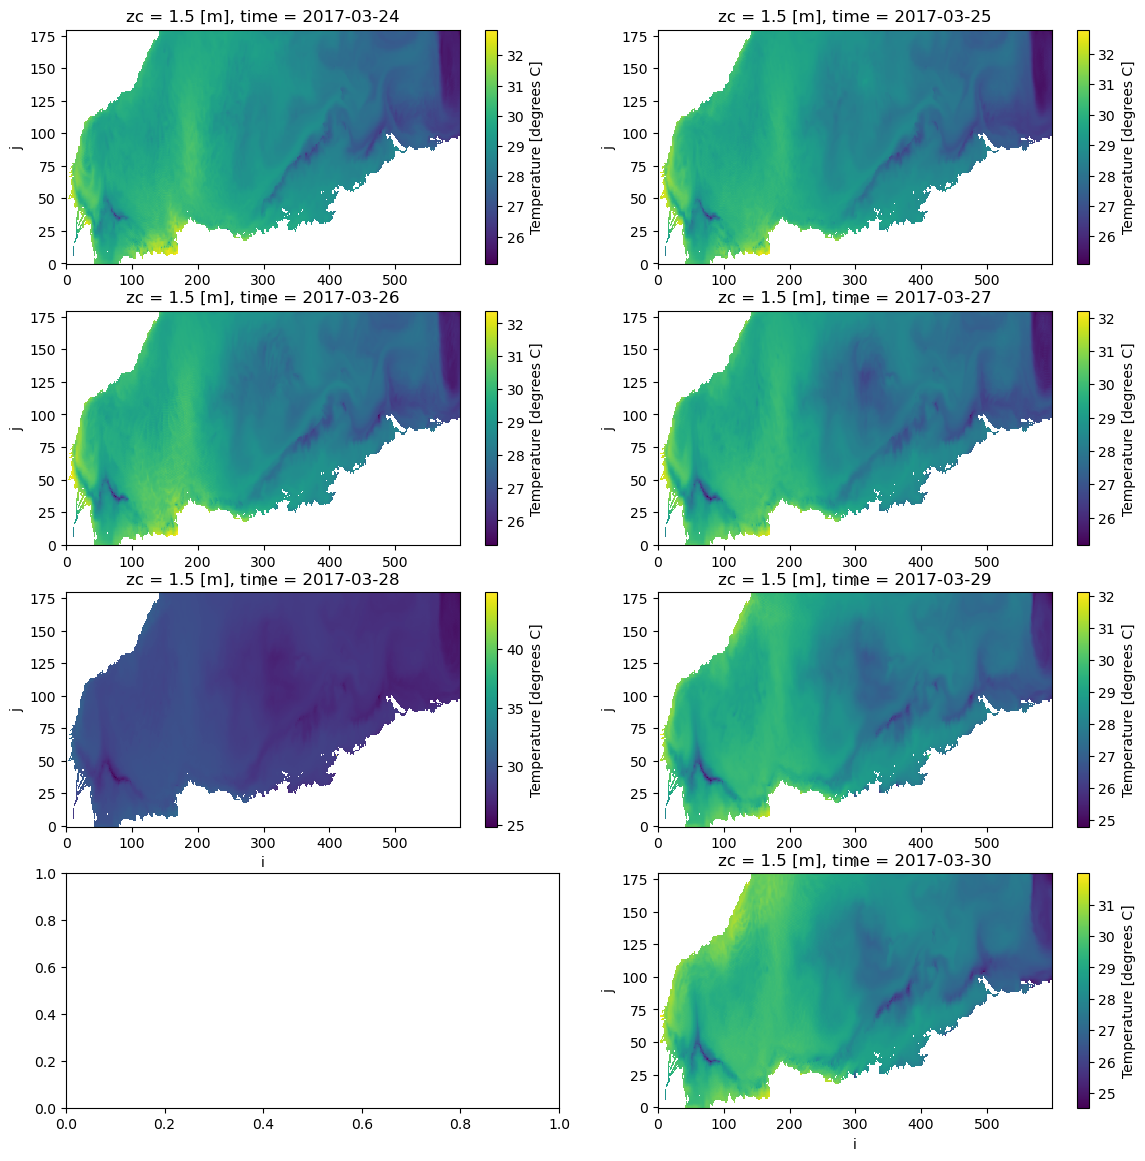

In [19]:
fig,ax = plt.subplots(ncols=2, nrows=4, figsize=(14,14))
daily_mean_temp.sel(time='2017-03-24T00:00:00.000000000',k=-1).plot(ax=ax[0,0])
daily_mean_temp.sel(time='2017-03-25T00:00:00.000000000',k=-1).plot(ax=ax[0,1])
daily_mean_temp.sel(time='2017-03-26T00:00:00.000000000',k=-1).plot(ax=ax[1,0])
daily_mean_temp.sel(time='2017-03-27T00:00:00.000000000',k=-1).plot(ax=ax[1,1])
daily_mean_temp.sel(time='2017-03-28T00:00:00.000000000',k=-1).plot(ax=ax[2,0])
daily_mean_temp.sel(time='2017-03-29T00:00:00.000000000',k=-1).plot(ax=ax[2,1])
daily_mean_temp.sel(time='2017-03-30T00:00:00.000000000',k=-1).plot(ax=ax[3,1])